# Prévalence du Listeria dans le lait cru

In [1]:
!ls

README.md                 listeria.txt              projets2021.pdf
exploratoire_claire.ipynb mcmc.ipynb


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random as rd
import statistics as stats
import math
from math import gamma
from tqdm import tqdm

# Exploration rapide des données

In [2]:
data = pd.read_csv('listeria.txt', sep=',')
data.columns = ['nb_pos', 'nb_test']
new_row = {'nb_pos':0, 'nb_test':600}
data = data.append(new_row, ignore_index=True)
data['prob']=data["nb_pos"]/data['nb_test']
proba_constante = sum(data['nb_pos'])/sum(data['nb_test'])

In [3]:
# distribution du nombre de testés dans chaque étude

data['nb_test'].sort_values()

86         14
87         16
83         16
85         17
17         20
       ...   
40       1720
62       2009
44       2511
20       4046
18    1227053
Name: nb_test, Length: 91, dtype: int64

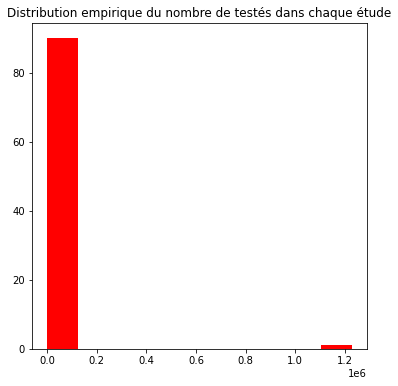

In [19]:
dg=data['nb_test']
plt.figure(figsize=(6,6))
plt.hist(dg, density=False,color="red")
plt.title("Distribution empirique du nombre de testés dans chaque étude")
plt.show()

On voit qu'une étude se distingue clairement des autres de par son ampleur. Il s'agit de l'étude 18 qui concerne 1 227 053 personnes !

In [20]:
# distribution du nombre de positifs dans chaque étude

data['nb_pos'].sort_values()

0       0
17      0
16      0
15      0
14      0
     ... 
44     79
69     85
79     90
62    102
18    278
Name: nb_pos, Length: 91, dtype: int64

Le nombre de positifs a l'air lui plus homogène entre chaque étude. Le plus grand nombre de positifs est pour l'étude 18 (assez cohérent car c'est elle qui a testé le plus de personnes). A priori donc, aucune raison d'enlever cette étude de nos données.

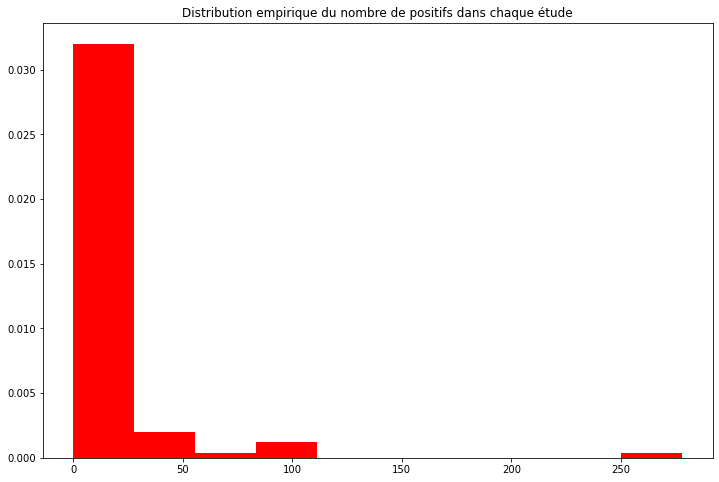

In [9]:
# distribution du nombre de positifs dans chaque étude

dg=data['nb_pos']
plt.figure(figsize=(12,8))
plt.hist(dg, density=True,color="red")
plt.title("Distribution empirique du nombre de positifs dans chaque étude")
plt.show()

In [25]:
# le plus important : distribution empirique de probabilité de positivité dans chaque étude

data['prob'].sort_values()

0     0.000000
17    0.000000
16    0.000000
15    0.000000
14    0.000000
        ...   
85    0.294118
86    0.428571
87    0.437500
88    0.452632
89    0.809524
Name: prob, Length: 91, dtype: float64

L'étude 89 affiche une probabilité empirique assez élevée, de presque $0.81$. On voit clairement que cette probabilité est supérieure à toutes les autres : 

Text(0.5, 1.0, 'Distribution des probas a priori empiriques')

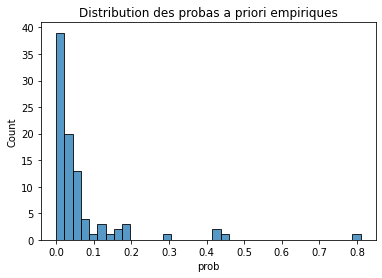

In [26]:
sns.histplot(data['prob'])
plt.title("Distribution des probas a priori empiriques")

Il faudra peut-être songer à l'enlever des données...

In [45]:
proba_constante

0.0010564383073439964

# Question 1 : détermination de la loi a posteriori

On suppose dans un premier temps que la probabilité de présence de listeria dans toutes les études est constante $p$.


Modèle binomial : $r_i \sim \mathcal{B}(n_i,p)$, de fonction de masse $f(r_i, p) = \binom{n_i}{r_i} p^{r_i} (1-p)^{n_i-r_i}$ 

Loi a priori : $p \sim \mathcal{B}eta(\alpha,\beta)$ avec $\alpha, \beta = 1$ ce qui revient à avoir $p \propto \mathcal{U}([0,1])$ donc de densité $\mathbb{1}_{[0,1]}(p)$

La densité de la loi a posteriori est alors ($n$=91 est le nombre d'études) : 

$\pi(p|r_1,\dots, r_n) \propto \prod_{i=1}^{n}f(r_i,p) \mathbb{1}_{[0,1]}(p) 
\\  \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,  \propto \prod_{i=1}^{n} p^{r_i} (1-p)^{(n_i-r_i)}\mathbb{1}_{[0,1]}(p)   \\  \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,  \propto p^{\sum_{i=1}^{n}r_i} (1-p)^{\sum_{i=1}^{n}(n_i-r_i)}\mathbb{1}_{[0,1]}(p)   \sim \mathcal{B}eta(\sum_{i=1}^{n}r_i +1, \sum_{i=1}^{n}(n_i-r_i)+1)$

Les observations nous permettent alors de calculer les deux paramètres de cette loi Bêta :


In [4]:
print("premier paramètre =",sum(data['nb_pos'])+1)
print("deuxième paramètre =",sum(data['nb_test'])-sum(data['nb_pos'])+1)

premier paramètre = 1329
deuxième paramètre = 1255727


Finalement, la loi a posteriori de $p$ est une $\boxed{\mathcal{B}eta(1329,1255727)}$

On n'utilise pas directement la fonction beta disponible dans le module stats de Python. En effet, du fait de la grande valeur des paramètres, il est préférable de reprogrammer par nous même une fonction gen_beta qui permet de tirer une valeur selon une loi beta

### Loi exponentielle 



In [10]:
def gen_exp(theta):
    u = rd.random()
    return -1/theta*np.log(1-u)

### Loi gamma

------------
Soient $X$ et $Y$ deux variables independantes distribuees suivant des lois  $\Gamma(a,1)$ et $\Gamma(b,1)$

Alors $U = X+Y$ et $V = X/(X+Y)$ sont deux variables independantes distribuees suivant des lois $\Gamma(a+b,1)$ et $\mathcal{B}eta(a,b)$.





In [28]:
def gama(x):
    l = [gen_exp(x) for i in range(10000)]
    return mean(l)
        
def f(x, a, b):
    return b**a*x**(a-1)*exp(-bx)/gamma(a)

In [77]:
def gen_gamma(a,b):
    # si alpha = 1, cela revient à avoir une loi exponentielle de paramètre beta
    if a == 1:
        return gen_exp(b)
    # si alpha est un entier non nul, gamma coïncide avec une somme de alpha va exponentielles
    # de paramètre beta indépendantes
    elif a == int(a) and a > 1 : 
        return sum([gen_exp(b) for i in range(a)])
    # sinon, on va utiliser une méthode de rejet 
    else : 
        while True : 
            # on va utiliser une loi de gamma de paramètres entiers pour g
            x = gen_gamma(int(a), b+1)
            # constante calculée dans la photo sur messenger
            c = b**a/((b+1)**int(a))*gama(int(a))/gama(a)*(a-int(a))**(a-int(a))*exp(-int(a)+a)
            u = rd.random()
            if u <= c*f(x, a, b)/g(x, int(a), b+1):
                return x 
        
        

### Loi Beta

In [78]:
def gen_beta(alpha, beta):
    X = gen_gamma(alpha, 1)
    Y = gen_gamma(beta,1)
    return X/(X+Y)

In [32]:
# on genere désormais notre beta(1329,1255727)

distr = [gen_beta(1329,1255727) for i in range(1000)]


In [27]:
# probabiliré agrégeé dans nos données, qu'on va comparer avec la distribution de notre loi a posteriori

proba_constante = sum(data['nb_pos'])/sum(data['nb_test'])
proba_constante

0.0010564383073439964

/home/guillot/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Distribution de la loi a posteriori')

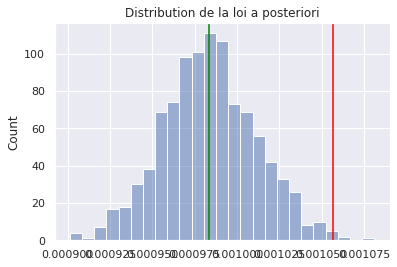

In [33]:
sns.set(style="darkgrid")
sns.histplot(distr, kde=True)
plt.axvline(proba_constante, color='red',label="probabilité agrégée trouvée dans les données")
p_esp = sum(distr)/len(distr)
plt.axvline(p_esp, color="green",label="probabilité agrégée trouvée dans la loi a posteriori")
plt.legend()
plt.title("Distribution de la loi a posteriori")

Le modèle n'approche pas très bien la probabilité agrégée de la présence de listeria (c'est-à-dire celle prise en agrégant l'ensemble des études).
De plus, on a vu que les études affichent des probabilités empiriques de présence de listeria assez variées. Il paraît donc plus judicieux de considérer des probabilités de présence de listeria $p_i$ qui varient avec l'étude $i$.$\newline$C'est l'objet de la deuxième question.

## Question 2 : 

On suppose dans un second temps que la probabilité de présence de listeria est variable selon les études.  

Modèle binomial : $r_i \sim \mathcal{B}(n_i,p_i)$, de fonction de masse $f(r_i, p_i) = \binom{n_i}{r_i} p_i^{r_i} (1-p_i)^{n_i-r_i}$

Loi a priori : $ \forall i, p_i \sim \mathcal{B}eta(\alpha,\beta)$, de densité $\displaystyle{\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}}p_i^{\alpha-1}(1-p_i)^{\beta-1}\mathbb{1}_{[0,1]}(p_i)$

L'énoncé propose la reparamétrisation suivante : $\mu = \alpha/(\alpha+\beta) \sim \mathcal{U}([0,1])$ et $\kappa = \alpha + \beta \sim \mathcal{E}(0.1)$

On supposera que : $\textbf{$\kappa$ et $\mu$ sont indépendantes}$ 

Donc on aura la densité jointe de $(\mu,\kappa)$ suivante : $p(\mu,\kappa)$ = $0.1 e^{-0.1\kappa}\mathbb{1}_{[0 ; \infty[}(\kappa)\mathbb{1}_{[0,1]}(\mu)$
     
En inversant : $\alpha = \kappa \mu $ et $\beta = \kappa (1-\mu)$

Et donc $p_i$ a pour densité (sachant $\mu$ et $\kappa$) : $p(p_i|\mu,\kappa)$  = $\displaystyle{\frac{\Gamma(\kappa)}{\Gamma(\kappa \mu)\Gamma(\kappa (1-\mu))}}p_i^{\kappa \mu-1}(1-p_i)^{\kappa(1-\mu)-1}\mathbb{1}_{[0,1]}(p_i)$

La densité de la loi a posteriori est alors : 

$\pi(\mu,\kappa,p_1,...,p_n|r_1,\dots, r_n) \propto \left(\prod_{i=1}^{n}f(r_i,p_i)p(p_i|\mu,\kappa)\right)p(\mu,\kappa)
\\    \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,  \propto \left(\prod_{i=1}^{n} p_i^{r_i} (1-p_i)^{(n_i-r_i)}\displaystyle{\frac{\Gamma(\kappa)}{\Gamma(\kappa \mu)\Gamma(\kappa (1-\mu))}}p_i^{\kappa \mu-1}(1-p_i)^{\kappa(1-\mu)-1}\mathbb{1}_{[0,1]}(p_i)\right)e^{-0.1\kappa}\mathbb{1}_{[0 ; \infty[}(\kappa)\mathbb{1}_{[0,1]}(\mu)  
\\    \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,  \propto e^{-0.1\kappa}\left(\displaystyle{\frac{\Gamma(\kappa)}{\Gamma(\kappa \mu)\Gamma(\kappa (1-\mu))}}\right)^n\left(\prod_{i=1}^{n} p_i^{r_i+\kappa \mu -1} (1-p_i)^{(n_i-r_i)+\kappa(1-\mu)-1}\mathbb{1}_{[0,1]}(p_i)\right)\mathbb{1}_{[0 ; \infty[}(\kappa)\mathbb{1}_{[0,1]}(\mu)$ 

Contrairement au cas précédent, la loi a posteriori ne correspond pas à une loi usuelle connue. 
On va alors mettre en oeuvre un algorithme de $\textbf{Metropolis within Gibbs}$ pour simuler cette loi a posteriori, en s'appuyant sur les différentes lois (connues) de nos paramètres $(p_i)_i,\kappa$ et $\mu$.

In [3]:
def indicatrice1(x):
    if x <1 and x>0:
        return 1
    else:
        return 0

def indicatrice2(x):
    if x >=0:
        return 1
    else:
        return 0


In [201]:
def metropolis_within_gibbs(x,sigma_1,sigma_2):
    mu=x[91]      # valeur précédente de mu
    kap=x[92]     # valeur précédente de kappa
    
    y=np.zeros(93)  #initialisation d'un vecteur y qui contiendra les valeurs à l'étape suivante
    
    for i in range(0,91):
        a = mu*kap+data['nb_pos'][i]
        b = data['nb_test'][i]-data['nb_pos'][i]+kap*(1-mu)
        y[i]=np.random.beta(a,b)
    
    z = mu + sigma_1 * np.random.randn()       # proposition pour la prochaine valeur de mu 
    
    if indicatrice1(z)==0:
        seuil=0
    else:
        quantite_1=((1/gamma(kap*z))*(1/gamma(kap*(1-z))))**91
        quantite_2=((1/gamma(kap*mu))*(1/gamma(kap*(1-mu))))**91
        quantite_3=(math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(kap*(z-mu))
        seuil=min(1,(quantite_1*quantite_3)/quantite_2)
                                                                   
    if np.random.rand() < seuil:             # on accepte z comme nouvelle valeur de mu
        y[91]=z
    
    else:
        y[91]=mu                             # on garde l'ancienne valeur de mu
    
    
    w = kap + sigma_2 * np.random.randn()         # proposition pour la prochaine valeur de kappa
    
    if indicatrice2(w)==0:
        seuil=0
    else:
        quantite_1=np.exp(-0.1*(w-kap))
        quantite_2=((gamma(w)/gamma(w*y[91]))*(1/gamma(w*(1-y[91]))))**91
        quantite_3=((gamma(kap)/gamma(kap*y[91]))*(1/gamma(kap*(1-y[91]))))**91
        quantite_4=(math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(y[91]*(w-kap))
        quantite_5=(math.prod([(1-y[i]) for i in range(0,91)]))**(w-kap)
        seuil=min(1,(quantite_1*quantite_2*quantite_4*quantite_5)/quantite_3)
        
    if np.random.rand() < seuil:             # on accepte w comme nouvelle valeur de kappa
        y[92]=w
    
    else:
        y[92]=kap                            # on garde l'ancienne valeur de kappa  

    
    return y      # on retourne le vecteur des nouvelles valeurs

In [202]:
# initialisation de notre vecteur y qui contiendra les valeurs successives de nos 93 paramètres (les 91 p_i + mu + kappa)

N = 10000
y = np.zeros((N, 93))

for i in range (0,91):
    y[0,i]=data['prob'][i]           # on prend les probas empiriques comme probas initiales
    
y[0,91]=0.5         # valeur initiale pour mu car mu suit une uniforme sur [0,1]
y[0,92]=10          # valeur initiale pour kappa car kappa suit une exp(0.1) donc est de moyenne 10


# generate chain

for n in tqdm(range(1, 10000)):
    y[n] = metropolis_within_gibbs(y[n-1],sigma_1=0.3,sigma_2=0.5)

100%|██████████| 9999/9999 [00:41<00:00, 243.39it/s]


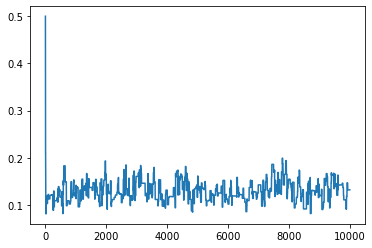

In [203]:
plt.plot(y[:,91])

# MCMC trace pour mu

On est censés tomber sur une loi uniforme au bout d'un moment, oscillant entre 0 et 1. Là ce n'est clairement pas le cas ! L'algo oscille plutôt entre 0 et 0.2, car la faible valeur de sigma_1 ne lui a pas permis d'explorer beaucoup de valeurs potentielles pour notre distribution mu (et notamment les valeurs de la plage supérieure entre 0.5 et 1).

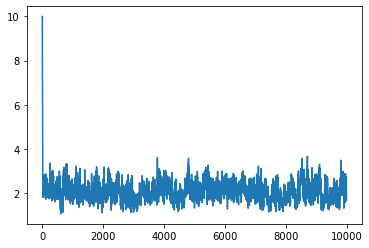

In [204]:
plt.plot(y[:,92])

# MCMC trace pour kappa

Idem : on est censés tomber sur une loi exponentielle au bout d'un moment, de moyenne 10. Là ce n'est clairement pas le cas ! L'algo est systématiquement en-dessous de 4. La faible valeur de sigma_2 ne lui a pas permis d'explorer beaucoup de valeurs potentielles pour notre distribution kappa (et notamment les valeurs supérieures à 10).

Solution : il faut augmenter les valeurs de sigma_1 et sigma_2 (par exemple à 0.3 et 10) mais quand on le fait, il y a une erreur numérique (le calcul d'une quantité mobilise trop de place). Illustration : 

In [205]:
# réinitialisation de y

N = 1000
y = np.empty((N, 93))

for i in range (0,91):
    y[0,i]=data['prob'][i]
y[0,91]=0.5
y[0,92]=10


for n in tqdm(range(1, 1000)):
    y[n] = metropolis_within_gibbs(y[n-1],sigma_1=0.3,sigma_2=10)

  0%|          | 0/999 [00:00<?, ?it/s]<ipython-input-201-fbf65cd40e52>:39: RuntimeWarning: overflow encountered in double_scalars
  seuil=min(1,(quantite_1*quantite_2*quantite_4*quantite_5)/quantite_3)
<ipython-input-201-fbf65cd40e52>:37: RuntimeWarning: overflow encountered in double_scalars
  quantite_4=(math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(y[91]*(w-kap))
  0%|          | 3/999 [00:00<00:05, 175.02it/s]


OverflowError: (34, 'Numerical result out of range')

Solution : reprogrammer la fonction gamma de Python car celle-ci tient trop de place + passer l'évaluation des seuils en log : 

# DEBUT

In [6]:
def gammar(x):
    if x>1:
        return (x-1)*gammar(x-1)
    else:
        return gamma(x)

In [56]:
def metropolis_within_gibbs_bis(x,sigma_1,sigma_2):
    mu=x[91]      # valeur précédente de mu
    kap=x[92]     # valeur précédente de kappa
    
    y=np.zeros(93)  #initialisation d'un vecteur y qui contiendra les valeurs à l'étape suivante
    
    for i in range(0,91):
        a = mu*kap+data['nb_pos'][i]
        b = data['nb_test'][i]-data['nb_pos'][i]+kap*(1-mu)
        y[i]=np.random.beta(a,b)
    
    z = mu + sigma_1 * np.random.randn()       # proposition pour la prochaine valeur de mu 
    
    if indicatrice1(z)==0:
        seuil=-np.inf
    else:
        quantite_1=-91*np.log(gammar(kap*z)*gammar(kap*(1-z)))
        quantite_2=-91*np.log(gammar(kap*mu)*gammar(kap*(1-mu)))
        quantite_3=(kap*(z-mu))*(sum([np.log(y[i]/(1-y[i])) for i in range(0,91)]))
        seuil=min(0,quantite_1+quantite_3-quantite_2)
                                                                   
    if np.log(np.random.rand()) < seuil:             # on accepte z comme nouvelle valeur de mu
        y[91]=z
    
    else:
        y[91]=mu                             # on garde l'ancienne valeur de mu
    
    
    w = kap + sigma_2 * np.random.randn()         # proposition pour la prochaine valeur de kappa
    
    if indicatrice2(w)==0:
        seuil=-np.inf
    else:
        quantite_1=-0.1*(w-kap)
        quantite_2=91*np.log(gammar(w)/(gammar(w*y[91])*gammar(w*(1-y[91]))))
        quantite_3=91*np.log(gammar(kap)/(gammar(kap*y[91])*gammar(kap*(1-y[91]))))
        quantite_4=(y[91]*(w-kap))*(sum([np.log(y[i]/(1-y[i])) for i in range(0,91)]))
        quantite_5=(w-kap)*(sum([np.log(1-y[i]) for i in range(0,91)]))
        seuil=min(0,(quantite_1+quantite_2+quantite_4+quantite_5)-quantite_3)
        
    if np.log(np.random.rand()) < seuil:             # on accepte w comme nouvelle valeur de kappa
        y[92]=w
    
    else:
        y[92]=kap                            # on garde l'ancienne valeur de kappa  

    
    return y      # on retourne le vecteur des nouvelles valeurs

In [61]:
# réinitialisation de notre vecteur y 

N = 10000
y = np.zeros((N, 93))

for i in range (0,91):
    y[0,i]=data['prob'][i]
y[0,91]=0.5
y[0,92]=10

w=np.zeros(N)
kap=np.zeros(N)
z=np.zeros(N)

for n in tqdm(range(1, 10000)):
    y[n] = metropolis_within_gibbs_bis(y[n-1],sigma_1=0.5,sigma_2=2)

100%|██████████| 9999/9999 [01:01<00:00, 161.82it/s]


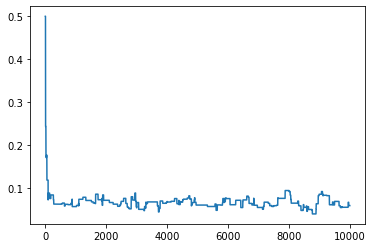

In [62]:
plt.plot(y[:,91])

# MCMC trace pour mu

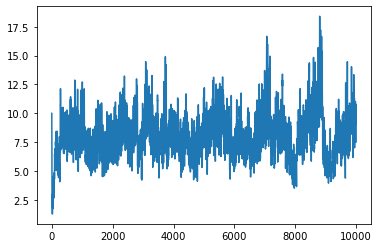

In [63]:
plt.plot(y[:,92])

# MCMC trace pour kappa

# STOP

Les résultats sont meilleurs ici : à partir de la 8000ème itération, la distribution ressemble à celle d'une uniforme (oscillations entre 0 et 1).
Concentrons-nous sur cette zone et comparons-là à celle d'une distribution uniforme :

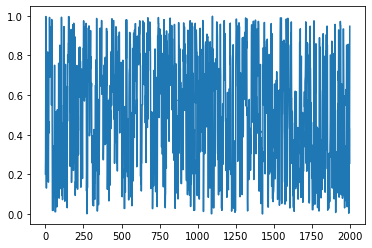

In [216]:
plt.plot(y[8000:,91])

In [217]:
print("moyenne =",np.mean(y[8000:,91]))          #  doit être "proche" de 0.5
print("variance =",np.var(y[8000:,91]))          # doit être "proche" de 1/12 = 0.083

moyenne = 0.510061956324882
variance = 0.08796453814091781


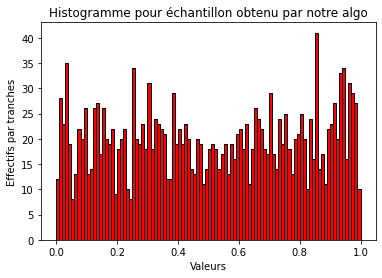

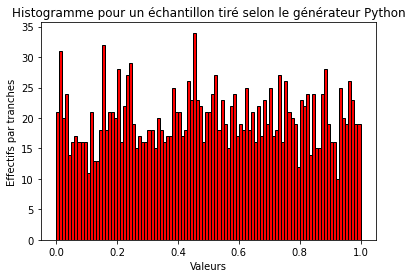

In [218]:
# Visulaisation de l'adéquation à la loi uniforme :

X=y[8000:,91]
plt.hist(X, range = (0, 1), bins = 100, color = 'red',edgecolor = 'black')
plt.xlabel('Valeurs')
plt.ylabel('Effectifs par tranches')
plt.title('Histogramme pour échantillon obtenu par notre algo')
plt.show()

Y=[rd.uniform(0,1) for i in range(8000,10000)]
plt.hist(Y, range = (0, 1), bins = 100, color = 'red',edgecolor = 'black')
plt.xlabel('Valeurs')
plt.ylabel('Effectifs par tranches')
plt.title("Histogramme pour un échantillon tiré selon le générateur Python")
plt.show()

Observations : pas trop de différences sur ce critère là entre notre distribution et celle d'une uniforme

In [219]:
# Test de Kolmogorov-Smirnov

import scipy.stats as statis

X=y[8000:,91]
Y=[rd.uniform(0,1) for i in range(8000,10000)]
D1,p1=statis.kstest(X, 'uniform', (0,1))
D2,p2=statis.kstest(Y, 'uniform', (0,1))

print("D1=",D1)
print("p-valeur_1=",p1)
print("D2=",D2)
print("p-valeur_2=",p2)

D1= 0.02992864928857708
p-valeur_1= 0.05447348842863864
D2= 0.01226787619415115
p-valeur_2= 0.9204836971348564


La p-valeur est petite pour notre échantillon X : on rejette l'hypothèse selon laquelle les données ont été générées selon une loi uniforme sur [0,1] ! 

Bilan : c'est un bon début mais il faut certainement prendre plus que 10000 itérations pour être sûr de sélectionner une zone où l'algo a déjà convergé.

d'autant que pour kappa, on n'obtient pas encore vraiment de distribution exponentielle (à l'itération 8000, on a encore des valeur aberrantes autour de 1000) : 

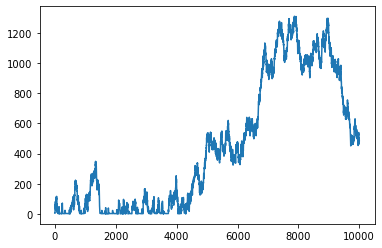

In [220]:
plt.plot(y[:,92])

# MCMC trace pour kappa

In [221]:
N = 20000                          # 20 000 itérations cette fois !
y = np.zeros((N, 93))

for i in range (0,91):
    y[0,i]=data['prob'][i]
y[0,91]=0.5
y[0,92]=5

w=np.zeros(N)
kap=np.zeros(N)
z=np.zeros(N)

for n in tqdm(range(1, 20000)):
    y[n] = metropolis_within_gibbs_bis(y[n-1],sigma_1=0.3,sigma_2=10)

  0%|          | 0/19999 [00:00<?, ?it/s]<ipython-input-207-c9998b5ebc04>:35: RuntimeWarning: overflow encountered in double_scalars
  quantite_2=((gammar(w)/gammar(w*y[91]))*(1/gammar(w*(1-y[91]))))**91
<ipython-input-207-c9998b5ebc04>:39: RuntimeWarning: invalid value encountered in double_scalars
  seuil=min(1,(quantite_1*quantite_2*quantite_4*quantite_5)/quantite_3)
<ipython-input-207-c9998b5ebc04>:36: RuntimeWarning: overflow encountered in double_scalars
  quantite_3=((gammar(kap)/gammar(kap*y[91]))*(1/gammar(kap*(1-y[91]))))**91
<ipython-input-207-c9998b5ebc04>:20: RuntimeWarning: invalid value encountered in double_scalars
  seuil=min(1,(quantite_1*quantite_3)/quantite_2)
<ipython-input-207-c9998b5ebc04>:37: RuntimeWarning: overflow encountered in double_scalars
  quantite_4=(math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(y[91]*(w-kap))
<ipython-input-207-c9998b5ebc04>:19: RuntimeWarning: overflow encountered in double_scalars
  quantite_3=(math.prod([y[i]/(1-y[i]) for i in

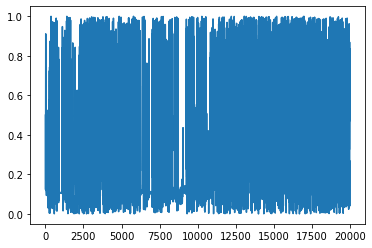

In [222]:
plt.plot(y[:,91])

# MCMC trace pour mu

Rq : paraît très bien !
Sélectionnons la zone après la 12500-ème itération : 

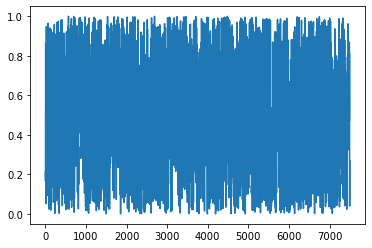

In [223]:
plt.plot(y[12500:,91])

In [224]:
print("moyenne =",np.mean(y[12500:,91]))          #  doit être "proche" de 0.5
print("variance =",np.var(y[12500:,91]))          # doit être "proche" de 1/12 = 0.083

moyenne = 0.5001679624496013
variance = 0.08165667329147024


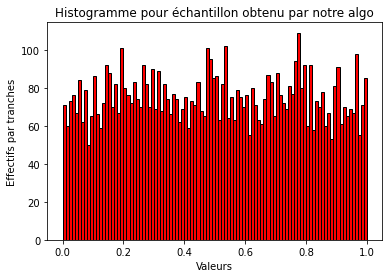

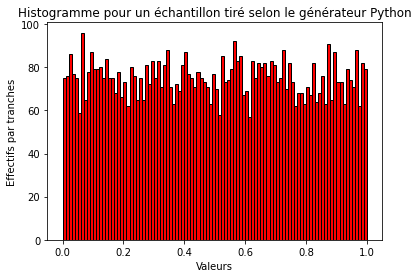

In [225]:
# Visualisation de l'adéquation à la loi uniforme :

X=y[12500:,91]
plt.hist(X, range = (0, 1), bins = 100, color = 'red',edgecolor = 'black')
plt.xlabel('Valeurs')
plt.ylabel('Effectifs par tranches')
plt.title('Histogramme pour échantillon obtenu par notre algo')
plt.show()

Y=[rd.uniform(0,1) for i in range(12500,20000)]
plt.hist(Y, range = (0, 1), bins = 100, color = 'red',edgecolor = 'black')
plt.xlabel('Valeurs')
plt.ylabel('Effectifs par tranches')
plt.title("Histogramme pour un échantillon tiré selon le générateur Python")
plt.show()

Cette fois, les distributions sont très voisines !

In [226]:
# Test de Kolmogorov-Smirnov


X=y[12500:,91]
Y=[rd.uniform(0,1) for i in range(5000,15000)]
D1,p1=statis.kstest(X, 'uniform', (0,1))
D2,p2=statis.kstest(Y, 'uniform', (0,1))

print("D1=",D1)
print("p-valeur_1=",p1)
print("D2=",D2)
print("p-valeur_2=",p2)

D1= 0.011824993689348223
p-valeur_1= 0.24316769498622903
D2= 0.007266105381463994
p-valeur_2= 0.6638044236614934


La p-valeur de notre distribution est cette fois élevée ($0.24$) : on ne rejette pas l'hypothèse selon laquelle nos données ont été génréees selon une loi uniforme !

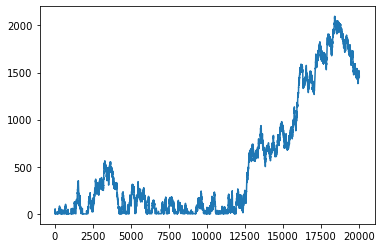

In [227]:
plt.plot(y[:,92])

# MCMC trace pour kappa

Ici, on n'obtient pas vraiment de distribution exponentielle... Il faut peut-être réduire la variance sigma_2

In [228]:
N = 20000                          # 20 000 itérations 
y = np.zeros((N, 93))

for i in range (0,91):
    y[0,i]=data['prob'][i]
y[0,91]=0.5
y[0,92]=5

w=np.zeros(N)
kap=np.zeros(N)
z=np.zeros(N)

for n in tqdm(range(1, 20000)):
    y[n] = metropolis_within_gibbs_bis(y[n-1],sigma_1=0.3,sigma_2=5)            # sigma_2=5 (contre 10 avant)

 11%|█▏        | 2284/19999 [00:09<01:11, 247.62it/s]<ipython-input-207-c9998b5ebc04>:35: RuntimeWarning: overflow encountered in double_scalars
  quantite_2=((gammar(w)/gammar(w*y[91]))*(1/gammar(w*(1-y[91]))))**91
<ipython-input-207-c9998b5ebc04>:39: RuntimeWarning: invalid value encountered in double_scalars
  seuil=min(1,(quantite_1*quantite_2*quantite_4*quantite_5)/quantite_3)
<ipython-input-207-c9998b5ebc04>:20: RuntimeWarning: invalid value encountered in double_scalars
  seuil=min(1,(quantite_1*quantite_3)/quantite_2)
<ipython-input-207-c9998b5ebc04>:36: RuntimeWarning: overflow encountered in double_scalars
  quantite_3=((gammar(kap)/gammar(kap*y[91]))*(1/gammar(kap*(1-y[91]))))**91
<ipython-input-207-c9998b5ebc04>:19: RuntimeWarning: overflow encountered in double_scalars
  quantite_3=(math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(kap*(z-mu))
<ipython-input-207-c9998b5ebc04>:37: RuntimeWarning: overflow encountered in double_scalars
  quantite_4=(math.prod([y[i]/(1-y[i])

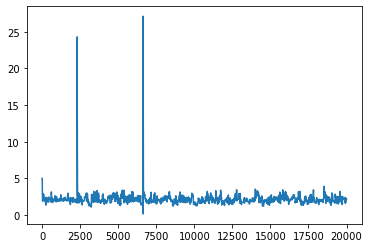

In [229]:
plt.plot(y[:,92])

# MCMC trace pour kappa

In [230]:
print("moyenne =",np.mean(y[10000:,92]))          #  doit être "proche" de 10
print("variance =",np.var(y[10000:,92]))          # doit être "proche" de 100

moyenne = 2.0752673756661117
variance = 0.15489440669660576


# Bilan partiel

A ce stade : pour mu =aucun souci

pour kappa = on arrive pas à trouver notre exponentielle

Si on arrive à trouver le pb, on a plus ou moins fini (car l'algo est alors valide, avec les variances optimales sigma_1 et sigma_2 égales à 0.3 et 10 qui sont celles de nos distributions cibles)

Et la question 3 reprend strictement la même chose sauf pour un mélange de lois beta


Supprimons l'étude 89

In [161]:
df = data[data['prob']<0.5]
df=df.reset_index(drop = True)

In [162]:
df

,nb_pos,nb_test,prob
0,0,415,0.000000
1,0,276,0.000000
2,0,220,0.000000
3,0,150,0.000000
4,0,142,0.000000
...,...,...,...
85,5,17,0.294118
86,6,14,0.428571
87,7,16,0.437500
88,43,95,0.452632


In [163]:
def metropolis_within_gibbs_4(x,sigma_1,sigma_2):
    mu=x[90]      # valeur précédente de mu
    kap=x[91]     # valeur précédente de kappa
    
    y=np.zeros(92)  #initialisation d'un vecteur y qui contiendra les valeurs à l'étape suivante
    
    for i in range(0,90):
        a = mu*kap+df['nb_pos'][i]
        b = df['nb_test'][i]-df['nb_pos'][i]+kap*(1-mu)
        y[i]=np.random.beta(a,b)
    
    z = mu + sigma_1 * np.random.randn()       # proposition pour la prochaine valeur de mu 
    
    if indicatrice1(z)==0:
        seuil=0
    else:
        quantite_1=((1/gammar(kap*z))*(1/gammar(kap*(1-z))))**91
        quantite_2=((1/gammar(kap*mu))*(1/gammar(kap*(1-mu))))**91
        quantite_3=(math.prod([y[i]/(1-y[i]) for i in range(0,90)]))**(kap*(z-mu))
        seuil=min(1,(quantite_1*quantite_3)/quantite_2)
                                                                   
    if np.random.rand() < seuil:             # on accepte z comme nouvelle valeur de mu
        y[90]=z
    
    else:
        y[90]=mu                             # on garde l'ancienne valeur de mu
    
    
    w = kap + sigma_2 * np.random.randn()         # proposition pour la prochaine valeur de kappa
    
    if indicatrice2(w)==0:
        seuil=0
    else:
        quantite_1=np.exp(-0.1*90*(w-kap))
        quantite_2=((gammar(w)/gammar(w*y[90]))*(1/gammar(w*(1-y[90]))))**90
        quantite_3=((gammar(kap)/gammar(kap*y[90]))*(1/gammar(kap*(1-y[90]))))**90
        quantite_4=(math.prod([y[i]/(1-y[i]) for i in range(0,90)]))**(y[90]*(w-kap))
        quantite_5=(math.prod([(1-y[i]) for i in range(0,90)]))**(w-kap)
        seuil=min(1,(quantite_1*quantite_2*quantite_4*quantite_5)/quantite_3)
        
    if np.random.rand() < seuil:             # on accepte w comme nouvelle valeur de kappa
        y[91]=w
    
    else:
        y[91]=kap                            # on garde l'ancienne valeur de kappa  

    
    return y      # on retourne le vecteur des nouvelles valeurs

In [190]:
N = 50000                          # 50 000 itérations cette fois !
y = np.zeros((N, 92))

for i in range (0,90):
    y[0,i]=df['prob'][i]
y[0,90]=0.5
y[0,91]=1000

w=np.zeros(N)
kap=np.zeros(N)
z=np.zeros(N)

for n in tqdm(range(1, 50000)):
    y[n] = metropolis_within_gibbs_4(y[n-1],sigma_1=0.3,sigma_2=7)

  0%|          | 0/49999 [00:00<?, ?it/s]<ipython-input-21-da213bdf7879>:3: RuntimeWarning: overflow encountered in double_scalars
  return (x-1)*gammar(x-1)
<ipython-input-163-d92da9b3db18>:20: RuntimeWarning: invalid value encountered in double_scalars
  seuil=min(1,(quantite_1*quantite_3)/quantite_2)
<ipython-input-163-d92da9b3db18>:35: RuntimeWarning: invalid value encountered in double_scalars
  quantite_2=((gammar(w)/gammar(w*y[90]))*(1/gammar(w*(1-y[90]))))**90
<ipython-input-163-d92da9b3db18>:36: RuntimeWarning: invalid value encountered in double_scalars
  quantite_3=((gammar(kap)/gammar(kap*y[90]))*(1/gammar(kap*(1-y[90]))))**90
<ipython-input-163-d92da9b3db18>:19: RuntimeWarning: overflow encountered in double_scalars
  quantite_3=(math.prod([y[i]/(1-y[i]) for i in range(0,90)]))**(kap*(z-mu))
  0%|          | 3/49999 [00:00<28:13, 29.52it/s]<ipython-input-163-d92da9b3db18>:38: RuntimeWarning: overflow encountered in double_scalars
  quantite_5=(math.prod([(1-y[i]) for i in 

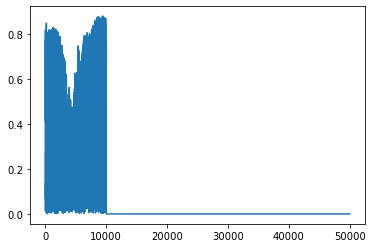

In [189]:
plt.plot(y[:,30])

# MCMC trace pour kappa

In [150]:
np.mean(y[0:20000,92])

29.55877909128595

In [112]:
def uniforme(a,b):
    return(a+(b-a)*rd.random())

In [129]:
def metropolis_within_gibbs_ter(x,eps1,eps2):
    mu=x[91]      # valeur précédente de mu
    kap=x[92]     # valeur précédente de kappa
    
    y=np.zeros(93)  #initialisation d'un vecteur y qui contiendra les valeurs à l'étape suivante
    
    for i in range(0,91):
        a = mu*kap+data['nb_pos'][i]
        b = data['nb_test'][i]-data['nb_pos'][i]+kap*(1-mu)
        y[i]=np.random.beta(a,b)
    
    z = uniforme(mu-eps1,mu+eps1)      # proposition pour la prochaine valeur de mu 
    
    if indicatrice1(z)==0:
        seuil=0
    else:
        quantite_1=((1/gammar(kap*z))*(1/gammar(kap*(1-z))))**91
        quantite_2=((1/gammar(kap*mu))*(1/gammar(kap*(1-mu))))**91
        quantite_3=(math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(kap*(z-mu))
        seuil=min(1,(quantite_1*quantite_3)/quantite_2)
                                                                   
    if np.random.rand() < seuil:             # on accepte z comme nouvelle valeur de mu
        y[91]=z
    
    else:
        y[91]=mu                             # on garde l'ancienne valeur de mu
    
    
    w = uniforme(kap-eps2,kap+eps2)        # proposition pour la prochaine valeur de kappa
    
    if indicatrice2(w)==0:
        seuil=0
    else:
        quantite_1=np.exp(-0.1*91*(w-kap))
        quantite_2=((gammar(w)/gammar(w*y[91]))*(1/gammar(w*(1-y[91]))))**91
        quantite_3=((gammar(kap)/gammar(kap*y[91]))*(1/gammar(kap*(1-y[91]))))**91
        quantite_4=(math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(y[91]*(w-kap))
        quantite_5=(math.prod([(1-y[i]) for i in range(0,91)]))**(w-kap)
        seuil=min(1,(quantite_1*quantite_2*quantite_4*quantite_5)/quantite_3)
        
    if np.random.rand() < seuil:             # on accepte w comme nouvelle valeur de kappa
        y[92]=w
    
    else:
        y[92]=kap                            # on garde l'ancienne valeur de kappa  

    
    return y      # on retourne le vecteur des nouvelles valeurs

In [137]:
N = 10000                          # 10 000 itérations 
y = np.zeros((N, 93))

for i in range (0,91):
    y[0,i]=data['prob'][i]
y[0,91]=0.5
y[0,92]=10

w=np.zeros(N)
kap=np.zeros(N)
z=np.zeros(N)

for n in tqdm(range(1, 1000)):
    y[n] = metropolis_within_gibbs_bis(y[n-1],0.3,1)

100%|██████████| 999/999 [00:05<00:00, 196.07it/s]


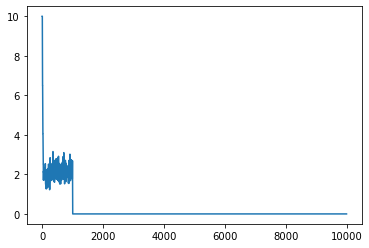

In [138]:
plt.plot(y[:,92])

# MCMC trace pour mu